In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

In [3]:
import os
import pickle
import numpy as np
from scipy import sparse
from functools import partial
from sklearn.externals import joblib
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from midi_ml.models.n_tuple import NTupleClassifier

In [4]:
labels = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_labels.pkl")
features = joblib.load("/home/jovyan/persistent_data/data/dumps/labeled_corpus_matrix.pkl")
features = features.todense()
mozart_labels = [k for k in range(len(labels)) if labels[k] == "mozart"]
bach_labels = [k for k in range(len(labels)) if labels[k] == "bach-js"]
schubert_labels = [k for k in range(len(labels)) if labels[k] == "schubert"]
chopin_labels = [k for k in range(len(labels)) if labels[k] == "chopin"]
tchaikovsky_labels = [k for k in range(len(labels)) if labels[k] == "tchaikovsky"]
X = features[mozart_labels + bach_labels + schubert_labels + chopin_labels + tchaikovsky_labels].A
y = np.array([0 for i in range(len(mozart_labels))] + [1 for i in range(len(bach_labels))] + 
            [2 for i in range(len(schubert_labels))] + [3 for i in range(len(chopin_labels))] +
            [4 for i in range(len(tchaikovsky_labels))])
y = y.reshape((y.shape[0],))
del features

In [5]:
X.shape

(3776, 16384)

In [6]:
import seaborn as sns
import pandas as pd

In [7]:
plot_df = pd.DataFrame({
    "composer": ["mozart", "bach", "schubert", "chopin", "tchaikovsky"],
    "num_records": [len(mozart_labels), len(bach_labels), len(schubert_labels), len(chopin_labels), len(tchaikovsky_labels)]
})

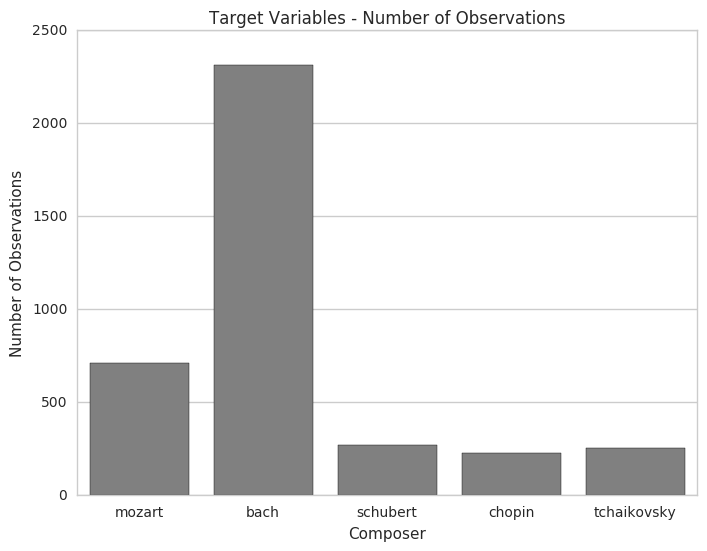

In [8]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
sns.barplot(x="composer", y="num_records",
            data=plot_df,
           color="gray")
plt.xlabel("Composer")
plt.ylabel("Number of Observations")
plt.title("Target Variables - Number of Observations")
plt.show()

In [207]:
np.unique(y, return_counts=True)[1][2:].sum()

749

In [6]:
from sklearn.linear_model import LogisticRegression

In [17]:
X = X[:,X.sum(axis=0).nonzero()[0]]

In [ ]:
predicted = []
actuals = []
models = []
i = 0
for train_idx, test_idx in KFold(n=X.shape[0], n_folds=5, shuffle=True):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    nt = NTupleClassifier(X_train, y_train,
                              M=400, L=3, num_bins=5)
    nt.fit_init()
    a = time.time()
    nt.fit_optimize(num_iter=100, num_folds=3)
    b = time.time()
    preds = nt.predict(X_test)
    predicted.append(preds)
    actuals.append(y_test)
    models.append(nt)
    pickle.dump(models, open("./dumps/ntuple/nt_model_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    pickle.dump(predicted, open("./dumps/ntuple/predicted_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    pickle.dump(actuals, open("./dumps/ntuple/actuals_fold_{fold}.pkl"
                                .format(fold=str(i)), 'wb'))
    i += 1

In [113]:
print(b-a)

8846.717688083649


In [116]:
from sklearn import metrics

In [195]:
import seaborn as sns
from scipy.stats.distributions import beta
def posterior_overlap_eval(actual, pred, labels, granularity=10000):
    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
    tp_fn = []
    confusion = metrics.confusion_matrix(actual, pred)
    for i in range(confusion.shape[0]):
        tp = confusion[i,i]
        fn = np.delete(confusion[i,:], i).sum()
        tp_fn.append((tp, fn))
    betas = [beta(a=1 + tp, b = 1 + fn) for tp, fn in tp_fn]
    for i, beta_dist in enumerate(betas):
        random_draws = beta_dist.rvs(granularity)
        plt.hist(random_draws, alpha=0.2, color=colors[i], bins=np.linspace(0,1, 100))
        plt.vlines(random_draws.mean(), 0, 3000, label=labels[i], color=colors[i], linestyles="dotted")
    plt.legend(loc="upper left")
    plt.show()

In [200]:
model_folder = "/home/jovyan/persistent_data/midi-ml/notebooks/ProjectTwoResults/dumps/ntuple/"
accuracy = []
precision = []
recall = []
f1 = []
mcc = []
post_overlaps = []
predicted = pickle.load(open(model_folder + "predicted_fold_4.pkl", 'rb'))
actuals = pickle.load(open(model_folder + "actuals_fold_4.pkl", 'rb'))
for preds, actual in zip(predicted, actuals):
    pred = preds
    print("confusion matrix")
    print(metrics.confusion_matrix(actual, pred))
    print("\taccuracy")
    acc = metrics.accuracy_score(actual, pred)
    accuracy.append(acc)
    print("\t\t", acc)
    print("\tf1")
    f = metrics.f1_score(actual, pred)
    f1.append(f)
    print("\t\t", f)
    print("\trecall")
    r = metrics.recall_score(actual, pred)
    recall.append(r)
    print("\t\t", r)
    print("\tprecision")
    p = metrics.precision_score(actual, pred)
    precision.append(p)
    print("\t\t", p)

confusion matrix
[[ 54  75   9   1   0]
 [ 27 434   6   3   2]
 [  5  14  26   6  10]
 [  3  11   1  12   4]
 [  8  17   9   3  16]]
	accuracy
		 0.716931216931
	f1
		 0.695310981495
	recall
		 0.716931216931
	precision
		 0.689992641723
confusion matrix
[[ 44  97   4   0   2]
 [ 24 425   5   6   4]
 [  5  18  23   4   5]
 [  0  21   2  18   1]
 [  5  23   6   1  12]]
	accuracy
		 0.691390728477
	f1
		 0.659130978457
	recall
		 0.691390728477
	precision
		 0.664620232208
confusion matrix
[[ 45  87   5   2   5]
 [ 21 421  12   3   1]
 [  9  10  20   6  12]
 [  3  20   6  15   2]
 [  4  17  10   5  14]]
	accuracy
		 0.682119205298
	f1
		 0.653441348575
	recall
		 0.682119205298
	precision
		 0.650066150776
confusion matrix
[[ 42  87   4   3   2]
 [ 23 430   8   0   4]
 [  3  14  17   8   7]
 [  2  17   9  18   1]
 [  4  29   7   1  15]]
	accuracy
		 0.691390728477
	f1
		 0.659500094588
	recall
		 0.691390728477
	precision
		 0.662959931352
confusion matrix
[[ 37  97   5   1   3]
 [ 11 43

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample

In [204]:
np.max(accuracy)

0.71693121693121697

In [197]:
labs = ["mozart", "bach", "schubert", "chopin", "tchaikovsky"]

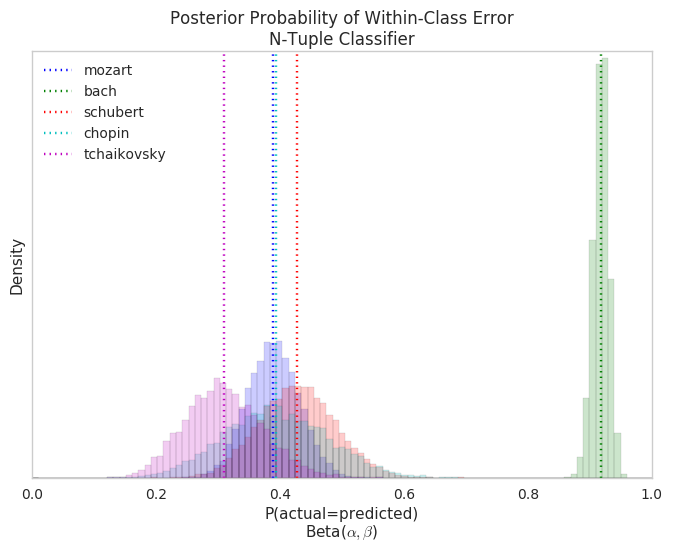

In [198]:
mymodel = "N-Tuple Classifier"
sns.set_style("whitegrid")
plt.title("Posterior Probability of Within-Class Error\n{model}".format(model=mymodel))
plt.xlabel('P(actual=predicted)\n' + r'Beta($\alpha, \beta$)')
plt.ylabel("Density")
plt.yticks([])
ax = plt.gca()
ax.grid(False)
posterior_overlap_eval(actual, pred, labels=labs, granularity=10000)